In [1]:
import warnings
warnings.filterwarnings('ignore')

import re
import json
import random
import os, sys
from os import path, makedirs
from pathlib import Path
from typing import List, Union, Tuple
from itertools import permutations, combinations

import time
import math
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append(os.getcwd())
sys.path.append(path.join(os.getcwd(), "TSB_UAD"))

from TSB_UAD.models.distance import Fourier
from TSB_UAD.models.feature import Window
# ! add ```plt.show()``` to utils/slidingWindow.py/plotFig to display plots
from TSB_UAD.utils.slidingWindows import find_length,plotFig, printResult
from sklearn.preprocessing import MinMaxScaler

from TSB_UAD.models.sand import SAND


In [2]:
sys.path.append(path.join(os.getcwd(), "EncDec-AD"))
from enc_dec_ad import EncDecAD

from collections import deque

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, average_precision_score, fbeta_score
from sklearn.metrics import confusion_matrix

from scipy.stats import ks_2samp
from tqdm import tqdm

In [3]:
# Setup GPU

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch
from torch.cuda import current_device, is_available
device = current_device() if is_available() else None
print(is_available(), device)

import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))  # list shouldn't be empty in case GPU is available 

tf.random.set_seed(42)
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

True 0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# load AE-LSTM model
sys.path.append(path.join(os.getcwd(), "redsofa_online_ae_lstm"))
from source.AELSTMOnline import AELSTMOnline
from source.baseAnomalyDetector import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, TimeDistributed, RepeatVector
from skmultiflow.data import FileStream

Number of GPUs Available:  1


In [5]:
# functions for loading datasets, handling results and making plots
sys.path.append(path.join(os.getcwd(), "utils"))
from utils.handle_datasets import *
from utils.handle_results_files import *
from utils.make_plots import *

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 5000)

<h1>1. Selected Time Series per Dataset</h1>
<p>16 public datasets, from which one series was randomly selected, with a preference for samples of larger lengths. These series will be used for normality 1 experiments. Additionally, pairs and triplets will be concatenated for normality levels 2 and 3 respectively (readers are referred to the respective experimentation sections). Characteristics for each of the selected series are presented in the results section of this notebook.</p>

In [6]:
DODGERS = 'Dodgers/101-freeway-traffic.test.out'
ECG = 'ECG/MBA_ECG803_data.out'
IOPS = 'IOPS/KPI-1c6d7a26-1f1a-3321-bb4d-7a9d969ec8f0.test.out'
KDD21 = 'KDD21/001_UCR_Anomaly_DISTORTED1sddb40_35000_52000_52620.out'
MGAB = 'MGAB/1.test.out'
NAB = 'NAB/NAB_data_Traffic_1.out'
SENSORSCOPE = 'SensorScope/stb-2.test.out'
YAHOO = 'YAHOO/Yahoo_A1real_1_data.out'
DAPHNET = 'Daphnet/S01R02E0.test.csv@1.out'
GHL = 'GHL/01_Lev_fault_Temp_corr_seed_11_vars_23.test.csv@4.out'
GENESIS = 'Genesis/genesis-anomalies.test.csv@1.out'
MITDB = 'MITDB/100.test.csv@1.out'
OPPORTUNITY = 'OPPORTUNITY/S1-ADL1.test.csv@16.out'
OCCUPANCY = 'Occupancy/room-occupancy.train.csv@3.out'
SMD = 'SMD/machine-1-1.test.csv@1.out'
SVDB = 'SVDB/801.test.csv@1.out'

ALL_SETS = [DODGERS, ECG, IOPS, KDD21, MGAB, NAB, SENSORSCOPE, YAHOO, DAPHNET, GHL, GENESIS, MITDB, OPPORTUNITY,
            OCCUPANCY, SMD, SVDB]

Series len = 78479
Normality = 2
Distro shift indexes = [50000]


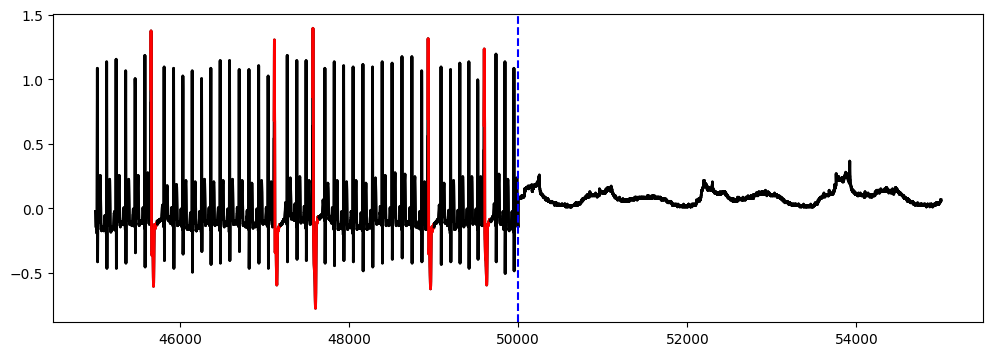

In [7]:
# How to load a dataset. For normality>1, add multiple time series files to the filenames list

filenames = [ECG, SMD]
df, normality, shift_idxs = load_dataset(filenames, sample_size=50000)


<h1>2. Methodology: Model Definitions</h1>
<p>This section includes the setup of the proposed models and baselines:
<ul>
    <li>SAND: A distance/cluster-based algorithm for streaming anomaly detection (AD).</li>
    <li>EncDec-AD: An LSTM-based autoencoder model proposed for offline AD.</li>
    <li>EncDec-AD-Batch: A naive streaming variation of EncDec-AD that operates independently in each data batch.</li>
    <li>OnlineEncDec-AD: A streaming variation of EncDec-AD incorporating incremental learning and concept drift detection mechanisms.</li>
    <li>AE-LSTM: An additional LSTM-based autoencoder baseline following a similar setup with the proposed OnlineEncDec-AD model.</li>
</ul>
The code for SAND, EncDec-AD and AE-LSTM models can be found on dedicated directories in the base directory of this project. The training and evaluation setup of the two streaming variants of EncDec-AD can be found in this notebook in dedicated subsections. 
</p>

<h2>2.1. SAND method</h2>
<h3>[Q5] Streaming baseline AD method</h3>

In [7]:

def SAND_model(df: pd.DataFrame, filenames: List[str], normality: int):
    
    name = "_".join(filenames)
    modelName='SAND'
    start_time = time.time()
    
    # process data
    data = df[0]
    label = df[1]
    slidingWindow = find_length(data)
    
    print("Estimated Subsequence length: ",slidingWindow)
    print("Time series length: ",len(data))
    print("Number of abnormal points: ",list(label).count(1))
    
    # train model 
    clf = SAND(pattern_length = slidingWindow, subsequence_length = 4*(slidingWindow))
    x = data
    clf.fit(x, online=True, alpha=0.5, init_length=5000, batch_size=5000, verbose=True, overlaping_rate=int(4*slidingWindow))
    
    # test
    score = clf.decision_scores_
    score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
    elapsed_time = time.time() - start_time
    # ! add ```plt.show()``` to utils/slidingWindow.py/plotFig to display plots
    plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName)
    
    # save results
    return gather_TSB_results(modelName, True, label, score, slidingWindow, filenames, normality, elapsed_time)


In [14]:
# SAND_model(df, filenames, normality)

<h2>2.2. EncDec-AD </h2>
<h3>[Q4] Offline/Non-streaming baseline method</h3>
<p>LSTM Encoder/Decoder methodology - DeepADoTS implementation</p>
    

In [8]:

def separate_sets(X, Y, train_perc=0.1, val_perc=0.0, first_shift_idx: int = None):
    
    train_idx = int(train_perc * len(X)) if first_shift_idx is None else int(train_perc * first_shift_idx)
    X_train, Y_train = X[:train_idx].reset_index(drop=True), Y[:train_idx].reset_index(drop=True)
    
    if val_perc > 0.0:
        val_idx = int(val_perc * len(X))
        X_val, Y_val = X[train_idx:train_idx + val_idx].reset_index(drop=True), \
                       Y[train_idx:train_idx + val_idx].reset_index(drop=True)
    else:
        X_val, Y_val = None, None
    
    test_idx = train_idx + (val_idx if val_perc > 0.0 else 0)
    X_test, Y_test = X[test_idx:].reset_index(drop=True), Y[test_idx:].reset_index(drop=True)

    return X_train, Y_train, X_val, Y_val, X_test, Y_test


In [9]:

def EncDecAD_model(df: pd.DataFrame, filenames: List[str], normality: int, shift_idx: List[int]=None, online_mode=False):
    name = "_".join(filenames)
    modelName = "EncDec-AD"
    start_time = time.time()
    
    # prepare dataset
    X = df[[0]]
    Y = df[1]
    n_features = X.shape[1]
    slidingWindow = find_length(X[0])
    first_shift_idx = None if normality==1 or shift_idx is None else shift_idx[0]
    X_train, Y_train, X_val, Y_val, X_test, Y_test = separate_sets(X, Y, train_perc=0.2, val_perc=0, first_shift_idx=first_shift_idx)
    slidingWindow = min(slidingWindow, X_train.shape[0])
    print('sliding window = ', slidingWindow)

    # train
    p = len(str(slidingWindow)) - 1
    p = pow(10, p)
    batch_size = min(int(4 * (slidingWindow // p) * p), X_train.shape[0])
    model = EncDecAD(n_features = n_features,
                     hidden_size = 32,
                     sequence_length = slidingWindow,
                     gpu = device)
    model.fit(X_train, num_epochs=40, batch_size=batch_size)

    # test
    score, loss = model.predict(X_test, batch_size=batch_size)
    elapsed_time = time.time() - start_time
    
    if online_mode:
        return score, X_test, Y_test
    else:
        # show evaluation results
        score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
        plotFig(X_test[0], Y_test, score, slidingWindow, fileName=name, modelName=modelName)
        return gather_TSB_results(modelName, online_mode, Y_test, score, slidingWindow, filenames, normality, elapsed_time)
    
    

In [16]:
# EncDecAD_model(df, filenames, normality, shift_idx, online_mode=False)

<h2>2.3. EncDec-AD-Batch </h2>
<h3>[Q6] Naive streaming variant (1):<br> Offline method is applied to each batch of the data that arrives. No modification of the method itself.</h3>
<p>Offline method: LSTM Encoder/Decoder - DeepADoTS implementation</p>


In [10]:

def create_stream(df: pd.DataFrame, stream_batch_size: int = 10000) -> List[pd.DataFrame]:
    # first stream batch boundaries
    start = 0
    end = min(stream_batch_size, df.shape[0])

    stream = []
    while start <df.shape[0] and end <= df.shape[0]:
        stream_batch = df.iloc[start:end].reset_index(drop=True)
        stream.append(stream_batch)

        # move on to the next batch of the stream
        start += stream_batch_size
        end += stream_batch_size
        end = min(end, df.shape[0])

    # in case the last batch is smaller than the seq len, concat it with the previous batch
    sequence_len = find_length(stream[0][0])
    if stream[-1].shape[0] < sequence_len:
        stream[-2] = pd.concat([stream[-2], stream[-1]], ignore_index=True)
        stream = stream[:-1]
    return stream


In [11]:

def EncDecAD_Batch_model(df: pd.DataFrame, filenames: List[str], normality:int, stream_batch_size:int=10000):
    modelName = "EncDec-AD-Batch"
    stream = create_stream(df, stream_batch_size)
    start_time = time.time()

    # for gathering stream results
    score = np.empty(0)
    X_test = pd.DataFrame(columns=[0])
    Y_test = pd.Series(dtype=df[1].dtype)

    for i, batch in enumerate(stream):
        print(f"Batch {i+1}/{len(stream)} with # {batch.shape[0]} points")
        # apply non-streaming method on each batch independently
        batch_score, batch_X_test, batch_Y_test = EncDecAD_model(batch, filenames, normality, online_mode=True)

        # append batch results
        score = np.concatenate((score, batch_score), axis=0)
        X_test = pd.concat([X_test, batch_X_test], ignore_index=True)  # needed for plotFig func
        Y_test = pd.concat([Y_test, batch_Y_test], ignore_index=True)  # points used for training are excluded from testing

        # move on to the next branch
        
    # show evaluation results on the whole stream
    elapsed_time = time.time() - start_time
    sliding_window = find_length(df[0])
    score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
    plotFig(X_test[0], Y_test, score, sliding_window, fileName="_".join(filenames), modelName=modelName)
    return gather_TSB_results(modelName, True, Y_test, score, sliding_window, filenames, normality, elapsed_time)



In [19]:
# EncDecAD_Batch_model(df, filenames, normality, batch_size=int(df.shape[0] / 10))


<h2>2.4. EncDec-AD-Online </h2>
<h3>[Q6] Streaming variant 2: Streaming Anomaly Detection with Incremental Learning and Concept Drift Detection<br></h3>
<p>In the realm of time series anomaly detection, adapting to continuously arriving data points in a streaming setting is crucial for timely and accurate detection of anomalies. We propose an online adaptation of the EncDec-AD model, originally designed for offline detection using an LSTM autoencoder architecture. In our approach, the model is initially trained on a specified percentage of the initial data stream to establish a baseline. Subsequently, it undergoes incremental learning, updating its parameters in real-time as new data arrives. To address concept drift, which can significantly affect model performance, we integrate a Kolmogorov-Smirnov (KS) test to monitor reconstruction errors. This test detects significant changes in the error distribution, triggering a complete retraining of the model when necessary. Additionally, the anomaly score threshold is dynamic and determined by the theta-percentile, calculated with linear interpolation. This combination of initial training, incremental learning, and concept drift detection ensures that the EncDec-AD model remains accurate and responsive to changes in the data stream, making it well-suited for real-time anomaly detection in dynamic environments. This model was inspired by the AE-LSTM and strAEm++DD models.
    
Summary:
<ul>
    <li>The EncDec-AD model (an LSTM Autoencoder) is initially trained using a percentage (train_perc) of the initial points in the data stream. </li> 
    <li>It is subsequently updated through incremental learning.</li> 
    <li>A concept drift detection mechanism monitors the model's predictions (reconstruction errors) and triggers the model to be retrained from scratch when significant changes are detected.</li> 
    <li>Dynamic annomaly score threshold determined by the theta-precentile.</li>
</ul>
</p>
    

In [12]:

class CapacityQueue:
    def __init__(self, queue_capacity, with_replacement=False):
        self.replaced_elements = None
        self.total_elements = None
        self.queue = None

        self.queue_capacity = queue_capacity  # Maximum capacity of the queue
        self.with_replacement = with_replacement
        self.reset()

    def __len__(self):
        return len(self.queue)

    def reset(self):
        self.queue = deque(maxlen=self.queue_capacity if self.with_replacement else None)  # Initialize deque with a fixed size
        self.total_elements = 0  # Total elements added
        self.replaced_elements = 0  # Number of elements replaced

    def push(self, x):
        if self.with_replacement and len(self.queue) == self.queue_capacity:
            # If the queue is full, increment replaced_elements
            self.replaced_elements += 1
        self.queue.append(x)
        self.total_elements += 1

    def isFull(self):
        return len(self.queue) >= self.queue_capacity

    def percentage_replaced(self):
        if self.total_elements < self.queue_capacity:
            return 0  # No replacement has occurred if the total elements added is less than capacity
        return (self.replaced_elements / self.total_elements) * 100

    def copy_from(self, other):
        self.queue = deque(other.queue, maxlen=other.queue_capacity)
        self.total_elements = other.total_elements
        self.replaced_elements = other.replaced_elements
        
# ======================================================================================================

class OnlineAD:

    def __init__(self,
                 df: pd.DataFrame,
                 filenames: List[str],
                 normality: int,
                 shift_idx: List[int] = None,
                 Wincrem: int = 1000, Wdrift: int = 200,
                 max_buffer_len: int = 2000,
                 incremental_cutoff: int = 50,
                 percentile_cutoff: int = 92,
                 ks_significance_level: float = 0.001,
                 training_epochs: int = 40,
                 incremental_training_epochs: int = 10,
                 use_increm_learning: bool = True,
                 use_concept_drift: bool = True,
                 use_dynamic_thrs: bool = True,
                 verbose: int = 0
                 ):
        self.name = "OnlineEncDecAD"
        self.v = verbose
        self.training_epochs = training_epochs
        self.incremental_training_epochs = incremental_training_epochs
        self.max_buffer_len = max_buffer_len
        
        self.use_increm_learning = use_increm_learning
        self.use_concept_drift = use_concept_drift
        self.use_dynamic_thrs = use_dynamic_thrs

        self.Wincrem = Wincrem
        self.Wdrift = Wdrift
        self.incremental_cutoff = incremental_cutoff
        self.percentile_cutoff = percentile_cutoff
        self.ks_significance_level = ks_significance_level

        self.X, self.Y = None, None
        self.sequence_length = None
        self.n_features = None
        self.model = None
        self.theta_t = None
        self.drift_idxs = []
        self.increm_idxs = []
        self.initialize(df, shift_idx)

        self.errors = []
        self.Y_hat = []
        self.pred_buffer= CapacityQueue(self.max_buffer_len)
        self.wnd_increm = CapacityQueue(self.Wincrem, True)
        self.wnd_drift  = CapacityQueue(self.Wdrift)
        self.wnd_ref    = CapacityQueue(self.Wdrift)

        start_time = time.time()
        self.parse_stream()
        self.get_predictions()
        self.elapsed_time = time.time() - start_time
        self.extract_results(filenames, normality)

    # -----------------------------------------------------------------------------------------------
  
    def initialize(self, df: pd.DataFrame, shift_idx: List[int]):
        X = df[[0]]
        Y = df[1]
        self.n_features = X.shape[1]

        # drift windows (Wdrift size) should be at least as large as the sequence
        self.sequence_length = find_length(X[0])
        if self.sequence_length > self.Wdrift:
            self.Wdrift = int(self.sequence_length)

        first_shift_idx = None if shift_idx is None or len(shift_idx)==0 else shift_idx[0]
        X_init_train, Y_init_train, _, _, self.X, self.Y = separate_sets(X, Y, train_perc=0.2, val_perc=0, first_shift_idx=first_shift_idx)
        print(f"Seq len = {self.sequence_length}\nInitializing model with {X_init_train.shape[0]} samples...")
        self.fit_model(X_init_train, True, 0)


    def fit_model(self, X: Union[pd.DataFrame, CapacityQueue], reset_model: bool, t:int):

        if reset_model:
            self.model = EncDecAD(
                n_features = self.n_features,
                hidden_size = 32,
                sequence_length = self.sequence_length,
                gpu = device)
            epochs = self.training_epochs
        else:
            epochs = self.incremental_training_epochs

        X = self.toDF(X)

        if self.v>=1: print(f"\nTraining model ({'from scratch' if reset_model else 'incremental'}) with {X.shape} samples")
        if reset_model: self.drift_idxs.append(t)
        else: self.increm_idxs.append(t)

        self.model.fit(X, epochs, batch_size = self.get_batch_size(X), show_progress_bar=(self.v>=2 or t==0))
        
        if t==0 or self.use_dynamic_thrs:
            _, train_loss = self.model.predict(X)
            self.theta_t  = self.calc_percentile(train_loss)
            if self.v>=1: print(f"New theta_t = {self.theta_t}\n{'-'*30}")


    def calc_percentile(self, loss):
        return np.percentile(loss, self.percentile_cutoff, interpolation='linear')



    def predict_model(self, X: Union[pd.DataFrame, CapacityQueue], is_output: bool):
        X = self.toDF(X)

        _, loss = self.model.predict(X, batch_size = self.get_batch_size(X))
        Y_hat = (loss > self.theta_t).astype(int)

        if is_output:
            self.errors.append(loss)
            self.Y_hat.append(Y_hat)

        return loss


    # -------------------------------------------------------------------------------------------------
    def parse_stream(self):

        print(f"Parse stream with #{self.X.shape[0]} data points...")
        for (t, xt) in self.X.iterrows():
            if self.v==0 and t%5000==0: print(f"{t} ->", end='')
            
            self.pred_buffer.push(xt)

            if self.pred_buffer.isFull():   
                if self.v>=2: print(f"Predict buffer (# {len(self.pred_buffer)}) since full")
                self.predict_model(self.pred_buffer, True)
                self.pred_buffer.reset()

            if self.X.shape[0] - t > self.sequence_length:  # at least one sequence should remain in the stream
                if self.use_increm_learning:
                    self.incremental_training(t, xt)
                if self.use_concept_drift:
                    self.concept_drift_detection(t, xt)

        if len(self.pred_buffer) > 0:
            print(f"\nPredict last buffer (# {len(self.pred_buffer)}) before finish")
            self.predict_model(self.pred_buffer, True)
            self.pred_buffer.reset()



    def incremental_training(self, t, xt):
        self.wnd_increm.push(xt)
        if self.wnd_increm.isFull() or self.wnd_increm.percentage_replaced() >= self.incremental_cutoff:

            if self.v>=2: print(f"Incremental training (# {len(self.wnd_increm)}) at t = {t}"); self.printObjects()

            self.fit_model(self.wnd_increm, False, t)
            self.wnd_increm.reset()



    def concept_drift_detection(self, t, xt):
        if not self.wnd_ref.isFull():
            self.wnd_ref.push(xt)
        elif not self.wnd_drift.isFull():
            self.wnd_drift.push(xt)
        else:
            ref_loss = self.predict_model(self.wnd_ref, False)
            drift_loss = self.predict_model(self.wnd_drift, False)
            drift_detected = self.check_for_drift(ref_loss, drift_loss, t)

            if drift_detected:
                if self.v>=2:
                    print(f"Drift detected at t = {t}")
                    self.printObjects()

                if len(self.pred_buffer) > self.sequence_length:
                    if self.v>=2: print(f"Predict buffer (# {len(self.pred_buffer)})  before drift reset step")
                    self.predict_model(self.pred_buffer, True)
                    self.pred_buffer.reset()

                self.fit_model(self.wnd_drift, True, t)
                self.wnd_ref.reset()
                self.wnd_drift.reset()
                self.wnd_increm.reset()
            else:
                self.wnd_ref.copy_from(self.wnd_drift)
                self.wnd_drift.reset()
                if self.v>=2:
                    print(f"No Drift at t = {t}"); self.printObjects()



    def check_for_drift(self, ref_loss: np.ndarray, drift_loss: np.ndarray, t:int):
        """:return: 
            True:  The two distributions are significantly different (reject H0).
            False: The two distributions are not significantly different (fail to reject H0).
        """""
        ks_statistic, p_value = ks_2samp(ref_loss.ravel(), drift_loss.ravel())
        if self.v>=2: print(f"Checked for drift p-value = {p_value} at t = {t}")
        return p_value < self.ks_significance_level


    # -------------------------------------------------------------------------------------------------

    def toDF(self, X):
        if isinstance(X, pd.DataFrame):
            return X
        elif isinstance(X, CapacityQueue):
            return pd.DataFrame(X.queue)
        else:
            ValueError(f"Invalid x type: {type(X)}")


    def get_batch_size(self, X):
        data_len = X.shape[0] if isinstance(X, pd.DataFrame) else len(X)
        p = len(str(self.sequence_length)) - 1
        p = pow(10, p)
        batch_size = min(int(4 * (self.sequence_length // p) * p), data_len)
        return batch_size

    def get_predictions(self):
        self.errors = np.concatenate(self.errors, axis=1).ravel()
        self.Y_hat  = np.concatenate(self.Y_hat, axis=1).ravel()
        
        
    def results(self):
        
        target_names = ['normal', 'anamoly']
        print("Accuarcy: " + str(accuracy_score(self.Y, self.Y_hat)))
        print("AUC: " + str(roc_auc_score(self.Y, self.Y_hat)))
        print("AUC PR: " + str(average_precision_score(self.Y, self.Y_hat)))
        print(confusion_matrix(self.Y, self.Y_hat))
        print(classification_report(self.Y, self.Y_hat, target_names=target_names, digits=4))

        return {'name': self.name,
                'Accuarcy': str(accuracy_score(self.Y, self.Y_hat)),
                'AUC': str(roc_auc_score(self.Y, self.Y_hat)),
                'AUC PR': str(average_precision_score(self.Y, self.Y_hat)),
                'confusion matrix': confusion_matrix(self.Y, self.Y_hat),
                'report': (classification_report(self.Y, self.Y_hat, target_names=target_names, digits=4, output_dict=True))}

    
    def extract_results(self, filenames, normality):
        results = self.results()
        ablation_study = not self.use_increm_learning or not self.use_concept_drift or not self.use_dynamic_thrs
        additional_stats = {
            "ablation": ablation_study,
            "use_increm_learn": self.use_increm_learning,
            "use_drift_detect": self.use_concept_drift,
            "use_dynamic_thrs": self.use_dynamic_thrs,
            "increm_idxs": self.increm_idxs,
            "drift_idxs": self.drift_idxs,
            "ks_significance": self.ks_significance_level,
            "percentile": self.percentile_cutoff
        }
        print(additional_stats)
        results = gather_AELSTM_results(self.name, self.X.shape[0], 
                              filenames, normality, results, 
                              self.Y, self.Y_hat, self.sequence_length, self.elapsed_time, additional_stats,
                              ablation_study=ablation_study)
        plotFig(self.X[0], self.Y, self.Y_hat.astype(float), self.sequence_length, fileName="_".join(filenames), modelName=self.name)
    
    # -------------------------------------------------------------------------------------------------

    def printObjects(self, message= None):
        print(f"\twnd_ref : # {len(self.wnd_ref)}\t {message}")
        print(f"\twnd_drift : # {len(self.wnd_drift)}")
        print(f"\twnd_incre : # {len(self.wnd_increm)}")
        print(f"\tpred_buff : # {len(self.pred_buffer)}")
        
        

In [21]:
# model = OnlineAD(df, filenames, normality, verbose=0)

<h2>2.5. AE-LSTM (Online/Streaming) </h2>
<h3>[Q6] Streaming variant 2: Online model sourced from GitHub to serve as an additional baseline</h3>
<p>LSTM Autoencoder methodology - redsofa (official) implementation</p>


In [13]:

# helper functions from original repo (OnlineAnomalyDetection.py):

def get_file_stream(data_source, target_column):
    if target_column == None:
        stream = FileStream(data_source, allow_nan=True, n_targets=0)
    else:
        stream = FileStream(data_source, allow_nan=True, n_targets=1, target_idx=target_column)
    return stream


def genericDetectorSteps(_detector, data_source, target_column, max_samples, batch_size):
    """
    This function include the general steps for an algorithm to detect anomaly for streaming data.
    predict_and_update() will be different based on the class type.
    :param _detector: The detected algorithm we are going to use
    :param data_source: The dataset link 
    :param batch_size: size of data to send to algorithm to each iteration for anomaly detection
    :param max_samples: maximum number of samples sent
    :param timestamp_column: column name in the data source which represents timestamp
    :param target_column: column name in the data source which represents target column
    :return: detector object
    """    
    _detector.stream = get_file_stream(data_source, target_column)
    _detector.start_time = time.time()

    if _detector.isPretrain:
        _detector.pre_train(_detector.isSupervised)
    else:
        # if not pretrain, skip these data
        _detector.get_next_stream(_detector.initial_batch_training_size)

    while _detector.n_samples < max_samples and _detector.stream.has_more_samples():
        # For LSTM, we need to get next sequence instead of data
        X, y = _detector.get_next_sequence(batch_size)
        _detector.predict_and_update(X,y)

    _detector.end_time = time.time()
    return _detector

# run AE-LSTM Online AD model: =======================================================================


def LSTMOnline_model(
    df: pd.DataFrame,
    filenames: List[str],
    normality: int,
    initial_batch_training_size:int,
    neurons:int = 32,
    epochs:int = 30,
    target_column_idx:int = 1
):
    model_name = 'AE-LSTM'
    # save dataframe to a csv (temporarily)
    def prepare_dataset_dataframe() -> str:
        filenames_norm = [filename[:filename.find('/')+1] for filename in filenames]
        filenames_norm = re.sub(r'[^A-Za-z0-9_]',  '.',  "_".join(filenames))
        new_data_source = os.path.join("OUTPUTS", 'temp_dataframes', filenames_norm + "_converted.csv")
        os.makedirs(os.path.dirname(new_data_source), exist_ok=True)
        df.to_csv(new_data_source, index=False)
        return new_data_source
    
    max_samples = df.shape[0]
    new_data_source = prepare_dataset_dataframe()
    
    slidingWindow = find_length(df[0])
    p = len(str(slidingWindow)) - 1
    p = pow(10, p)
    batch_size = min(int(4 * (slidingWindow // p) * p), max_samples)
    
    # define model
    LSTM_model = LSTMOnline(name = model_name, 
        detector = AELSTMOnline(time_steps = int(slidingWindow), 
                                neurons = neurons, 
                                epochs = epochs, 
                                anomaly_rate = 30, 
                                n_batch = batch_size),
        data_source = new_data_source, 
        initial_batch_training_size = initial_batch_training_size,
        batch_size = batch_size, 
        max_samples = max_samples, 
        timestamp_column = None, 
        target_column = target_column_idx,
        isSupervised = False, 
        ifSaveResult = True, 
        isPretrain = True)
    
    # training
    start_time = time.time()
    LSTM_model = genericDetectorSteps(
        LSTM_model, new_data_source, target_column_idx, max_samples, batch_size)
    K.clear_session()
    
    # delete temporary file
    os.remove(new_data_source)
    
    # make predictions and show results
    results = LSTM_model.results()
    y_pred = np.array(LSTM_model.y_pred)
    label = df[1][initial_batch_training_size:].values
    elapsed_time = time.time() - start_time
    
    gather_AELSTM_results(model_name, df.shape[0], filenames, normality, results, label, y_pred, slidingWindow, elapsed_time)
    plotFig(df[0], label, y_pred, slidingWindow, fileName=new_data_source, modelName=model_name)
    
    return LSTM_model, y_pred, results


In [23]:
# model, y_pred, results = LSTMOnline_model(df, filenames, initial_batch_training_size=1000)

<h1>3. Run Experiments</h1>
<p>This section includes the code for excecuting the experiments of this study. The output of these cells was cleared after saving the results to output json files to reduce the size of this notebook. The results are instead presented in the next section.</p>

In [14]:
import traceback

SAND_ = "SAND"
ENC_DEC_AD_OFFLINE = "EncDec-AD"
ENC_DEC_AD_BATCH = "EncDec-AD-Batch"
ENC_DEC_AD_ONLINE = "OnlineEncDecAD"
AE_LSTM_ONLINE = "AE-LSTM"

def run_model_for_sets(model_name, sets: Union[List[str], List[List[str]]], check_if_results_exist:bool=False,
                       # arguments for OnlineEncDec-AD model (OnlineAD class)
                      onlineAD_use_increment=True, onlineAD_use_concept_drift=True, onlineAD_use_dynam_thrs=True
):
    failed_sets = []
    for i, filename in enumerate(sets):
        try:
            filenames = [filename] if isinstance(filename, str) else filename
            print(f"Set [{i}] = {filenames}")
            
            sample_size = 100000 if len(filenames)==1 else 50000
            df, normality, shift_idxs = load_dataset(filenames, sample_size=sample_size, plot_series=False)
            
            if check_if_results_exist:
                results_file = results_file_exists(filenames, normality, model_name, model_name not in [ENC_DEC_AD_OFFLINE])
                if results_file:
                    print(f"Results file already exists {results_file}. Skip", '\n', '-'*50, '\n')
                    continue
            
            if model_name == SAND_:
                results = SAND_model(df, filenames, normality)
                
            elif model_name == ENC_DEC_AD_OFFLINE:
                results = EncDecAD_model(df, filenames, normality, shift_idxs, online_mode=False)
                
            elif model_name == ENC_DEC_AD_BATCH:
                stream_batch_size = int(df.shape[0] / 10)
                results = EncDecAD_Batch_model(df, filenames, normality, stream_batch_size)
            
            elif model_name == ENC_DEC_AD_ONLINE:
                results = OnlineAD(df, filenames, normality, shift_idxs, verbose=0, 
                                   use_increm_learning=onlineAD_use_increment,
                                   use_concept_drift=onlineAD_use_concept_drift,
                                   use_dynamic_thrs=onlineAD_use_dynam_thrs)
                
            elif model_name == AE_LSTM_ONLINE:
                _,_,results = LSTMOnline_model(df, filenames, normality, initial_batch_training_size=1000)
                
            print(results, '\n', '-'*50, '\n')
        except Exception as e:
            failed_sets.append(filename)
            print(f"{filename} failed")
            traceback.print_exc()
        # time.sleep(60)
            
    return failed_sets


<h2>3.1. Normality 1 Experiments</h2>

In [ ]:
run_model_for_sets(SAND_, ALL_SETS, True)

In [ ]:
run_model_for_sets(ENC_DEC_AD_OFFLINE, ALL_SETS, True)

In [ ]:
run_model_for_sets(ENC_DEC_AD_BATCH, ALL_SETS, True)

In [ ]:
run_model_for_sets(ENC_DEC_AD_ONLINE, ALL_SETS, True)

In [ ]:
run_model_for_sets(AE_LSTM_ONLINE, ALL_SETS, True)

In [17]:
results_df = prepare_results_df(1, 5, True)
results_df = get_datasets_x_model_pivot_table(results_df, print_=False, save=False)
results_df

selected datasets #  16


,datasets,0. SAND_AUC,0. SAND_F,1. Offline-EncDec-AD_AUC,1. Offline-EncDec-AD_F,2. EncDec-AD-Batch_AUC,2. EncDec-AD-Batch_F,3. Online-EncDec-AD_AUC,3. Online-EncDec-AD_F,4. AE-LSTM_AUC,4. AE-LSTM_F
1,Daphnet,79.00,0.00,40.78,1.16,27.25,0.00,48.27,5.45,48.97,3.87
2,Dodgers,75.90,11.60,49.67,1.21,55.74,1.10,46.01,4.75,49.88,1.47
3,ECG,98.78,49.47,77.40,14.97,67.87,14.69,72.17,33.17,61.45,21.68
4,GHL,50.94,0.00,65.66,0.00,99.02,16.77,78.44,1.32,49.01,0.00
5,Genesis,0.26,0.00,96.86,18.30,92.34,0.00,91.40,6.08,91.55,10.50
6,IOPS,52.23,0.00,72.73,33.99,72.28,25.19,73.25,2.53,74.70,25.71
7,KDD21,88.52,12.54,70.77,8.69,67.65,8.92,62.72,5.16,49.41,1.22
8,MGAB,66.46,0.00,67.67,2.07,53.90,1.77,51.71,0.69,51.13,0.61
9,MITDB,98.13,56.02,37.83,1.21,39.91,1.51,46.36,1.51,49.10,1.81
10,NAB,42.79,0.00,47.12,2.26,56.79,1.20,61.60,26.60,56.87,21.16


<h2>3.2. Normality 2 Experiments</h2>

- Reject datasets that all or the majority of models showed low performance in normality 1 tests
- Get all combinations (size 2)/possible pairs for the remaining datasets (combinations not permutations)
- Sample at most 50k initial data points from the beginning of each series.
- Training for Offline EncDec-AD and initial training for Online EncDec-AD was performed on the initial 20% of points of the first series in the concatenated series.

In [ ]:
norm2sets = ALL_SETS.copy()
for low_perf_norm1_set in [DAPHNET, DODGERS, MITDB, 
                           OCCUPANCY, SVDB, KDD21]:
    norm2sets.remove(low_perf_norm1_set)
    
norm2sets = [list(pair) for pair in list(combinations(norm2sets, 2))]
print(len(norm2sets))
# norm2sets = random.sample(norm2sets, k=10)
# norm2sets

In [ ]:
get_k_normality_info(ALL_SETS, norm2sets, sample_size=50000, aggregate=True, split_columns=False)

In [ ]:
run_model_for_sets(SAND_, norm2sets, True)

In [ ]:
run_model_for_sets(ENC_DEC_AD_OFFLINE, norm2sets, True)

In [ ]:
run_model_for_sets(ENC_DEC_AD_BATCH, norm2sets, True)

In [ ]:
run_model_for_sets(ENC_DEC_AD_ONLINE, norm2sets, True)

In [ ]:
selected_norm2 = [
    [ECG, MGAB],[ECG, SMD],[ECG, SENSORSCOPE],[GENESIS, OPPORTUNITY],[IOPS, NAB],[IOPS, SMD],
    [MGAB, OPPORTUNITY],[MITDB,OCCUPANCY],[NAB, YAHOO], [OCCUPANCY,SVDB],[SENSORSCOPE,GHL],
    [SENSORSCOPE,SMD], [YAHOO, GENESIS]]
print(len(selected_norm2))
run_model_for_sets(AE_LSTM_ONLINE, selected_norm2, True)

<h2>3.3. Normality 3 Experiments</h2>
<p>For triple normality, triplets are generated by combining pairs of normality 2 series that share a common subseries. This ensures that the triplets maintain desired characteristics, such as similar lengths. Each triplet's subseries are then sorted once in ascending and once in descending  order of their anomaly ratios (AR), and both resulting normality 3 series are used for experiments.</p>

In [ ]:
results_df = prepare_results_df(2, 5, True)
results_df = results_df[results_df['datasets'] != "Average"]
pairs = results_df['datasets_full'].apply(tuple).unique()
triplets = set()

for pair1, pair2 in combinations(pairs, 2):
    if any(elem in pair1 for elem in pair2):
        triplet = tuple(sorted(set(pair1 + pair2)))
        triplets.add(triplet)
triples = [list(triplet) for triplet in triplets]

print("# 3-combinations = ", len(triples))

def sort_triplet(triplet, reverse):
    sorted_triplet = sorted(triplet, key=lambda x: 
                            norm1info[norm1info['datasets'] == x[:x.find('/')]]["anomaly rate"].values[0], 
                            reverse=reverse)
    return sorted_triplet

norm3sets = [sort_triplet(triplet, True) for triplet in triplets] + \
            [sort_triplet(triplet, False) for triplet in triplets]

print("# total combinations = ", len(norm3sets))
# for i, triplet in enumerate(norm3sets):
#    names = [s[:s.find('/')] for s in triplet]
#    print(i, names, "->\t", [ norm1info[norm1info["Series"] == s]['anomaly rate'].values[0] for s in names])

# norm3sets

In [ ]:
get_k_normality_info(ALL_SETS, norm3sets, sample_size=50000, aggregate=True, split_columns=False)

In [ ]:
run_model_for_sets(SAND_, norm3sets, True)

In [ ]:
run_model_for_sets(ENC_DEC_AD_OFFLINE, norm3sets, True)

In [ ]:
run_model_for_sets(ENC_DEC_AD_BATCH, norm3sets, True)

In [ ]:
run_model_for_sets(ENC_DEC_AD_ONLINE, norm3sets, True)

In [ ]:
run_model_for_sets(AE_LSTM_ONLINE, norm3sets, True)

<h2>3.4. OnlineEncDec-AD Ablation Study</h2>
<p>This section examines the significance of the key mechanisms in the OnlineEncDec-AD model, namely Concept Drift Detection (CDD), Incremental Learning (IL), and Dynamic Anomaly Threshold (DAT). The default model integrates all three mechanisms. To evaluate the individual contributions of each mechanism, we conducted an ablation study by disabling one mechanism at a time and comparing the results. Given the high computational demands of this study, we selected a representative subset of datasets across each level of normality (k=1, 2, and 3) for experimentation.</p>

Ablation study type : increm False, drift True, dyn thrs True

Set [0] = ['SMD/machine-1-1.test.csv@1.out', 'ECG/MBA_ECG803_data.out', 'IOPS/KPI-1c6d7a26-1f1a-3321-bb4d-7a9d969ec8f0.test.out']
Series len = 128479
Normality = 3
Distro shift indexes = [28479, 78479]
Seq len = 279
Initializing model with 5695 samples...


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [02:02<00:00,  3.06s/it]


Parse stream with #122784 data points...
0 ->5000 ->10000 ->15000 ->20000 ->25000 ->30000 ->35000 ->40000 ->45000 ->50000 ->55000 ->60000 ->65000 ->70000 ->75000 ->80000 ->85000 ->90000 ->95000 ->100000 ->105000 ->110000 ->115000 ->120000 ->
Predict last buffer (# 618) before finish
Accuarcy: 0.766590109460516
AUC: 0.7443377916902939
AUC PR: 0.09973057250539182
[[90350 27191]
 [ 1468  3775]]
              precision    recall  f1-score   support

      normal     0.9840    0.7687    0.8631    117541
     anamoly     0.1219    0.7200    0.2085      5243

    accuracy                         0.7666    122784
   macro avg     0.5530    0.7443    0.5358    122784
weighted avg     0.9472    0.7666    0.8352    122784

{'ablation': True, 'use_increm_learn': False, 'use_drift_detect': True, 'use_dynamic_thrs': True, 'increm_idxs': [], 'drift_idxs': [0, 558, 1117, 1676, 2235, 2794, 3353, 3912, 4471, 5030, 5589, 6148, 6707, 7266, 7825, 8384, 8943, 9502, 10061, 10620, 11179, 11738, 12297, 12856, 

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [02:01<00:00,  3.04s/it]


Parse stream with #122784 data points...
0 ->5000 ->10000 ->15000 ->20000 ->25000 ->30000 ->35000 ->40000 ->45000 ->50000 ->55000 ->60000 ->65000 ->70000 ->75000 ->80000 ->85000 ->90000 ->95000 ->100000 ->105000 ->110000 ->115000 ->120000 ->
Predict last buffer (# 784) before finish
Accuarcy: 0.8726869950482148
AUC: 0.5632272671192443
AUC PR: 0.053897646340807584
[[105973  11568]
 [  4064   1179]]
              precision    recall  f1-score   support

      normal     0.9631    0.9016    0.9313    117541
     anamoly     0.0925    0.2249    0.1311      5243

    accuracy                         0.8727    122784
   macro avg     0.5278    0.5632    0.5312    122784
weighted avg     0.9259    0.8727    0.8971    122784

{'ablation': True, 'use_increm_learn': True, 'use_drift_detect': False, 'use_dynamic_thrs': True, 'increm_idxs': [999, 1999, 2999, 3999, 4999, 5999, 6999, 7999, 8999, 9999, 10999, 11999, 12999, 13999, 14999, 15999, 16999, 17999, 18999, 19999, 20999, 21999, 22999, 23999, 2

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [02:19<00:00,  3.48s/it]


Parse stream with #122784 data points...
0 ->5000 ->10000 ->15000 ->20000 ->25000 ->30000 ->35000 ->40000 ->45000 ->50000 ->55000 ->60000 ->65000 ->70000 ->75000 ->80000 ->85000 ->90000 ->95000 ->100000 ->105000 ->110000 ->115000 ->120000 ->
Predict last buffer (# 617) before finish
Accuarcy: 0.426505082095387
AUC: 0.6262972754088105
AUC PR: 0.05716750918968345
[[47939 69602]
 [  814  4429]]
              precision    recall  f1-score   support

      normal     0.9833    0.4078    0.5766    117541
     anamoly     0.0598    0.8447    0.1117      5243

    accuracy                         0.4265    122784
   macro avg     0.5216    0.6263    0.3441    122784
weighted avg     0.9439    0.4265    0.5567    122784

{'ablation': True, 'use_increm_learn': True, 'use_drift_detect': True, 'use_dynamic_thrs': False, 'increm_idxs': [40411, 50476, 52993, 59426, 61104, 62223, 65019, 72849], 'drift_idxs': [0, 558, 1117, 1676, 2235, 2794, 3353, 3912, 4471, 5030, 5589, 6148, 6707, 7266, 7825, 8384, 

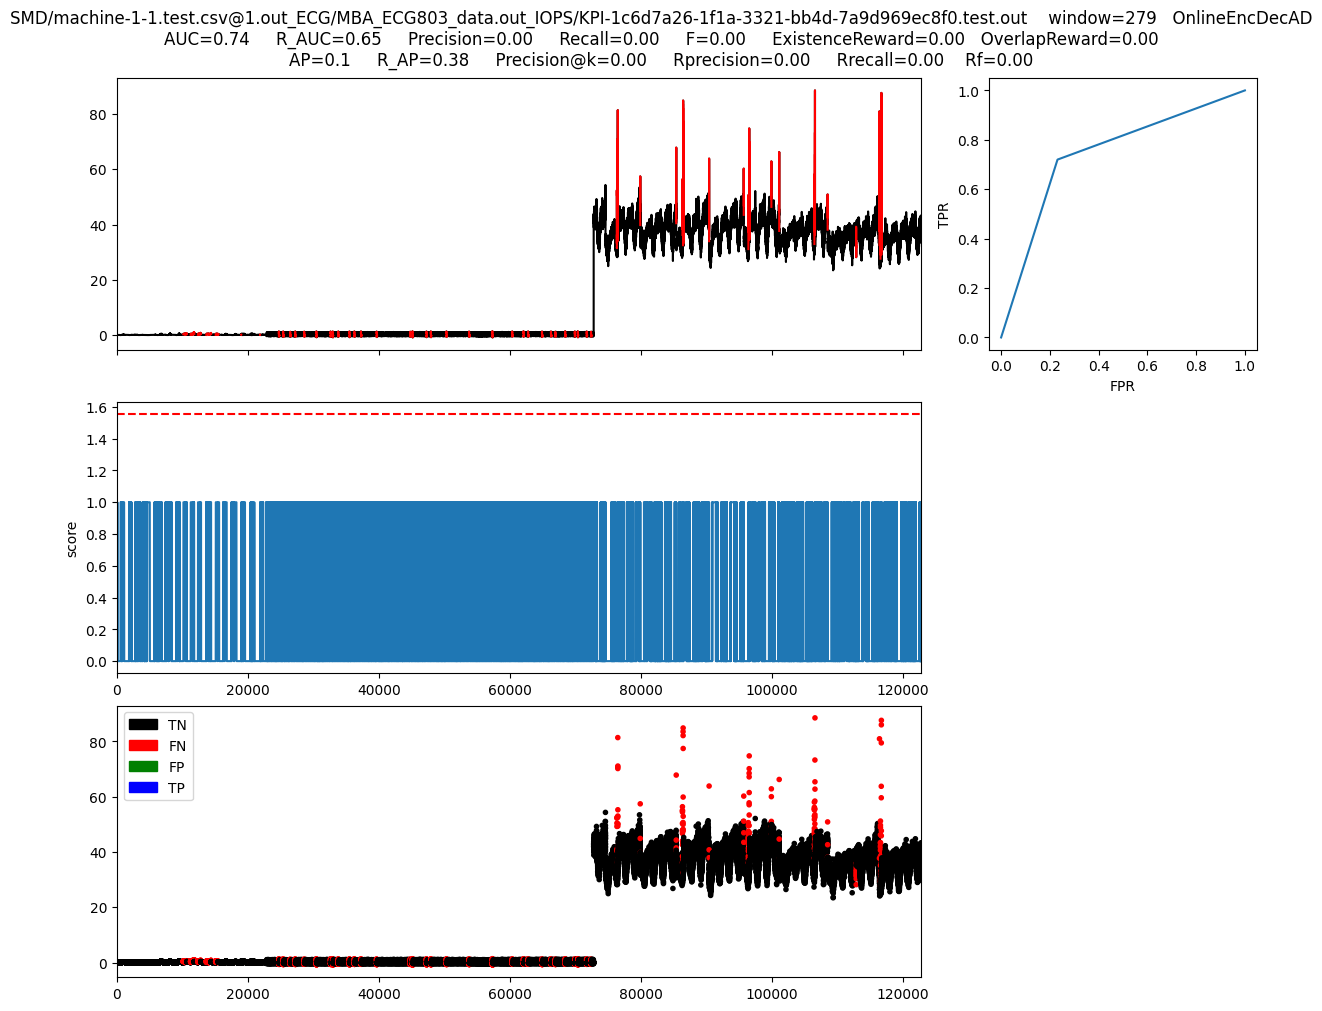

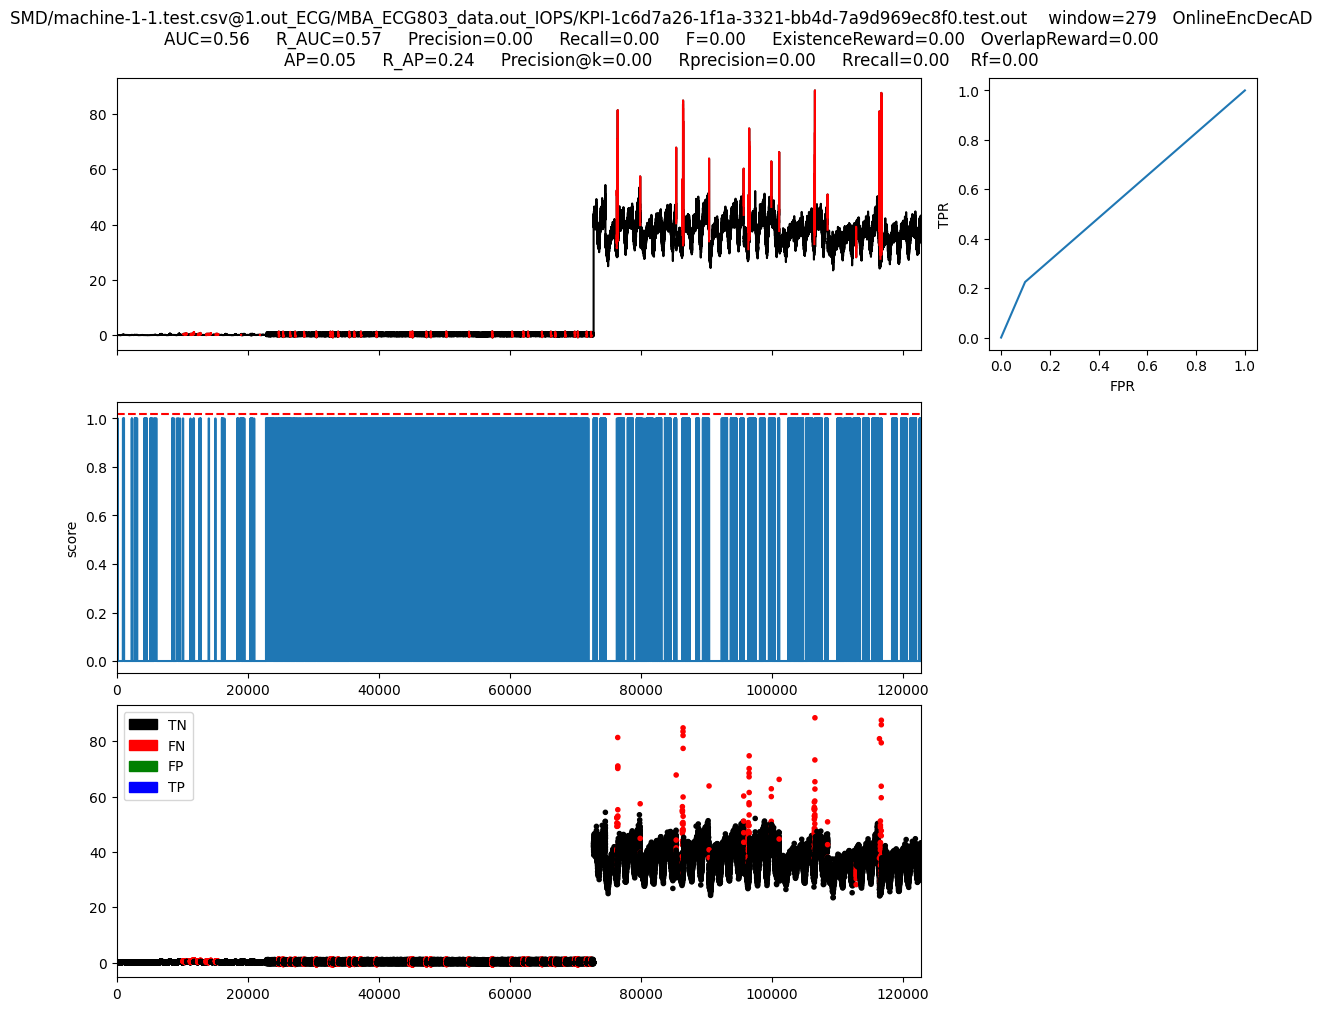

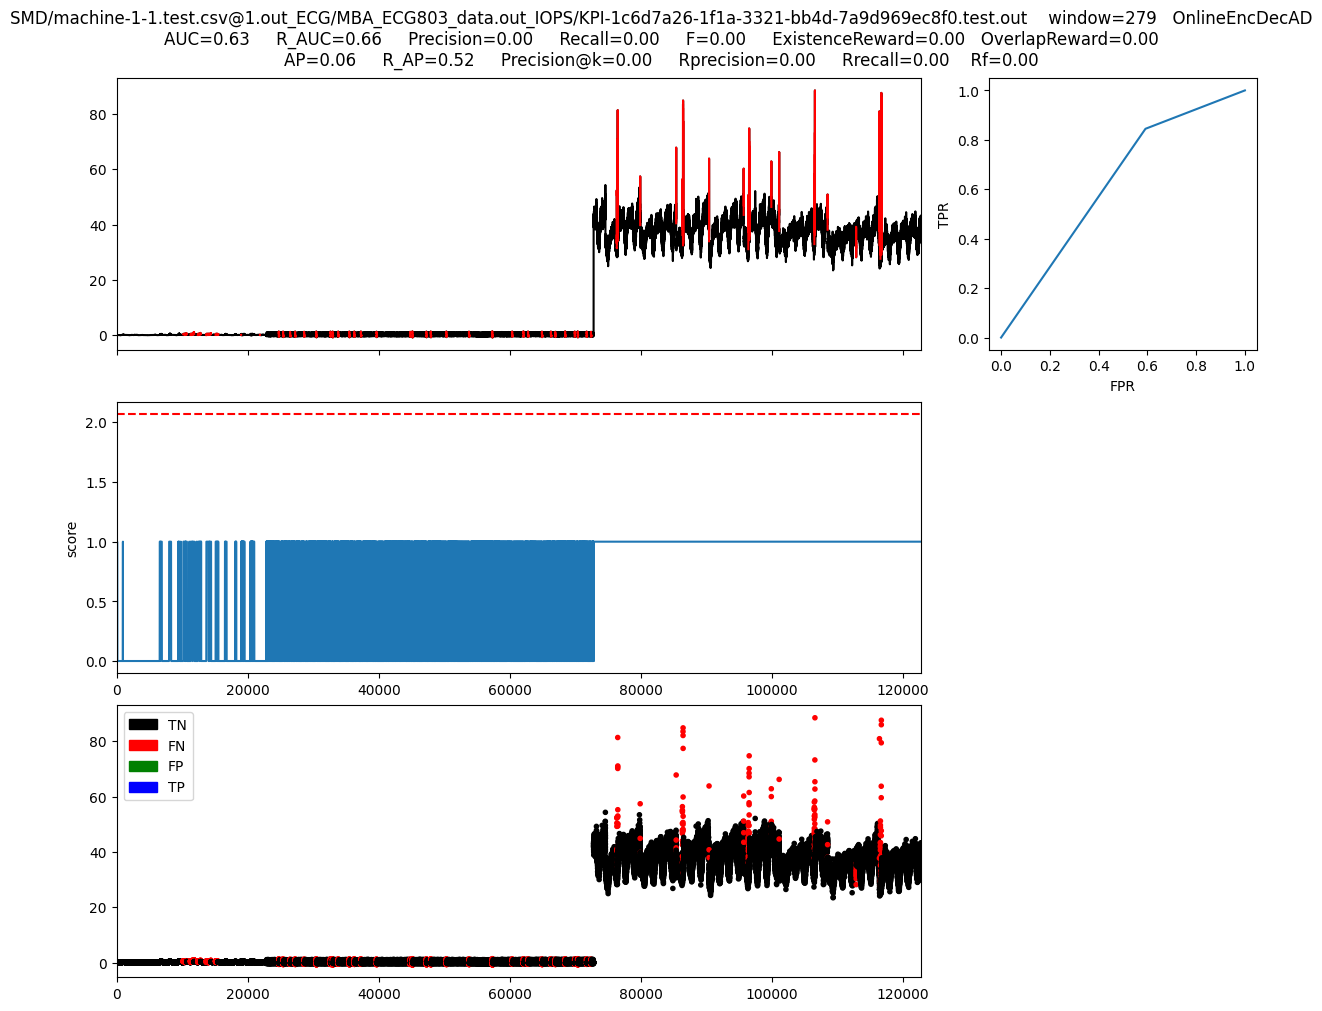

In [16]:
# normality 1
selected_sets = [
    [MGAB], [ECG], [OPPORTUNITY], [SENSORSCOPE], [DAPHNET], [IOPS], [MITDB], [NAB], [OCCUPANCY], [SMD]
]
# normality 2
selected_sets.extend([
    [SENSORSCOPE,SMD], [ECG,MGAB], [OCCUPANCY,SVDB], [MGAB,OPPORTUNITY]
])
# normality 3
selected_sets.extend([
    [IOPS,SMD,NAB],[SENSORSCOPE,ECG,GHL],[YAHOO,GENESIS,OPPORTUNITY], [SMD,ECG,IOPS]
])

for use_increm, use_concept_drift, used_dyn_thrs in [
    (False, True, True), # allow model reset. thrs recalculation only when drift detected
    (True, False, True), # allow incremental learning. thrs recalculation only at incremental step
    (True, True, False)  # allow both increm learning and drift detection. no thrs recalculation
]:
    print(f"Ablation study type : increm {use_increm}, drift {use_concept_drift}, dyn thrs {used_dyn_thrs}\n")
    run_model_for_sets(ENC_DEC_AD_ONLINE, selected_sets, check_if_results_exist=False,
        onlineAD_use_increment=use_increm, 
        onlineAD_use_concept_drift=use_concept_drift,
        onlineAD_use_dynam_thrs=used_dyn_thrs
    )
    

<h1>4. Experimental Results</h1>

<h2>4.1. Normality 1 Results</h2>

In [ ]:
normality = 1
results_df = prepare_results_df(normality, 5, False)
avg_values = results_df[results_df['datasets']=='Average']
results_df = results_df[results_df['datasets']!='Average']

pivot_map = get_datasets_x_model_pivot_table(results_df, save=False, print_=False).reset_index(drop=True)

<h3>4.1.1. Characteristics of each single normality dataset</h3>

In [ ]:
data_info = get_1_normality_info(ALL_SETS, 100000) if normality == 1 else \
            get_k_normality_info(ALL_SETS, pivot_map[['datasets']].values.flatten(), 50000, True, False)
n_characteristics = len([col for col in data_info.columns if not col.startswith('si')]) - 1
data_info

<h3>4.1.2. Results for each dataset and for each model</h3>

In [ ]:

merged_results = pd.merge(results_df, data_info, on='datasets')
merged_pivot = pd.merge(pivot_map, data_info, on='datasets')


In [ ]:
boxplots_comparing_models(results_df, "Performance across all datasets")

<h3>4.1.3. Assessing the impact of anomaly ratio on model performance</h3>

In [ ]:
boxplots_comparing_models(merged_results[merged_results['anomaly rate'] < 3], "Series with low anomaly rate (<3)")
boxplots_comparing_models(merged_results[merged_results['anomaly rate'] >= 3], "Series with high anomaly rate (>=3)")

<h3>4.1.4. Dataset characteristics/Model performance correlation</h3>

In [ ]:
correlations(merged_pivot, n_characteristics)

<h2>4.2. Normality 2 Results</h2>

In [ ]:
normality = 2
results_df = prepare_results_df(normality, 5, True)

avg_values = results_df[results_df['datasets']=='Average']
results_df = results_df[results_df['datasets']!='Average']

pivot_map = get_datasets_x_model_pivot_table(results_df, save=False, print_=False).reset_index(drop=True)


<h3>4.2.1. Characteristics of each double normality dataset</h3>

In [ ]:
data_info = get_k_normality_info(ALL_SETS, pivot_map[['datasets']].values.flatten(), 50000, True, False)
n_characteristics = len([col for col in data_info.columns if not col.startswith('si')]) - 1
data_info

<h3>4.2.2. Results for each dataset and for each model</h3>

In [ ]:
merged_results = pd.merge(results_df, data_info, on='datasets')
merged_pivot = pd.merge(pivot_map, data_info, on='datasets')


In [ ]:
boxplots_comparing_models(results_df, "Performance across all datasets")

<h3>4.2.3. Assessing the impact of different anomaly ratio trends on model performance</h3>

In [ ]:
boxplots_comparing_models(merged_results[merged_results['rate diff'] < 0], "Series where the anomaly rate decreases")
boxplots_comparing_models(merged_results[merged_results['rate diff'] > 0], "Series where the anomaly rate increases")

sorted_merged_pivot = pd.concat([
    merged_pivot[merged_pivot['rate diff'] < 0].sort_values(by=['rate diff'], ascending=False),
    merged_pivot[merged_pivot['rate diff'] > 0].sort_values(by=['rate diff'])
])

<h3>4.2.4. Dataset characteristics/Model performance correlation</h3>

In [ ]:
correlations(merged_pivot, n_characteristics)

<h2>4.3. Normality 3 Results</h2>

In [ ]:
normality = 3
results_df = prepare_results_df(normality, 5, True)

avg_values = results_df[results_df['datasets']=='Average']
results_df = results_df[results_df['datasets']!='Average']

pivot_map = get_datasets_x_model_pivot_table(results_df, save=False, print_=False).reset_index(drop=True)


<h3>4.3.1. Characteristics of each triple normality dataset</h3>

In [ ]:
data_info = get_k_normality_info(ALL_SETS, pivot_map[['datasets']].values.flatten(), 50000, True, False)
n_characteristics = len([col for col in data_info.columns if not col.startswith('si')]) - 1
data_info

<h3>4.3.2. Results for each dataset and for each model</h3>

In [ ]:
merged_results = pd.merge(results_df, data_info, on='datasets')
merged_pivot = pd.merge(pivot_map, data_info, on='datasets')


In [ ]:
boxplots_comparing_models(results_df, "Performance across all datasets")

<h3>4.3.3. Assessing the impact of different anomaly ratio trends on model performance</h3>

In [ ]:
boxplots_comparing_models(merged_results[merged_results['rate diff'] < 0], "Series where the anomaly rate decreases")
boxplots_comparing_models(merged_results[merged_results['rate diff'] > 0], "Series where the anomaly rate increases")

sorted_merged_pivot = pd.concat([
    merged_pivot[merged_pivot['rate diff'] < 0].sort_values(by=['rate diff'], ascending=False),
    merged_pivot[merged_pivot['rate diff'] > 0].sort_values(by=['rate diff'])
])

<h3>4.3.4. Dataset characteristics/Model performance correlation</h3>

In [ ]:
correlations(merged_pivot, n_characteristics)

<h2>4.4. OnlineEncDec-AD Ablation Study Results</h2>

In [ ]:
abl_study_res, avg_per_normality_and_model = get_ablation_study_results()

<h3>4.4.1. Ablation study on single normality datasets</h3>

In [ ]:
show_ablation_study_results_for_normality(abl_study_res, normality=1)

<h3>4.4.2. Ablation study on double normality datasets</h3>

In [ ]:
show_ablation_study_results_for_normality(abl_study_res, normality=2)

<h3>4.4.3. Ablation study on triple normality datasets</h3>

In [ ]:
show_ablation_study_results_for_normality(abl_study_res, normality=3)

<h2>4.5. Runtime Performance Analysis</h2>

In [ ]:
runtime_analysis()